In [ ]:
!pip install mediapipe

In [122]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

mp_facemesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates

%matplotlib inline

In [ ]:
# Landmark points corresponding to left eye
all_left_eye_idxs = list(mp_facemesh.FACEMESH_LEFT_EYE)
# flatten and remove duplicates
all_left_eye_idxs = set(np.ravel(all_left_eye_idxs))

# Landmark points corresponding to right eye
all_right_eye_idxs = list(mp_facemesh.FACEMESH_RIGHT_EYE)
all_right_eye_idxs = set(np.ravel(all_right_eye_idxs))

# Combined for plotting - Landmark points for both eye
all_idxs = all_left_eye_idxs.union(all_right_eye_idxs)

# The chosen 12 points:   P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/multicampus/team_project2/eyes_project/

/content/drive/MyDrive/multicampus/team_project2/eyes_project


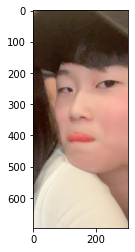

In [ ]:
# load the image
image = cv2.imread(r"test_img/test_open.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert to RGB
image = np.ascontiguousarray(image)
imgH, imgW, _ = image.shape

plt.imshow(image)

In [ ]:
image

In [ ]:
# Running inference using static_image_mode
with mp_facemesh.FaceMesh(
    static_image_mode=True,         # Default=False
    max_num_faces=1,                # Default=1
    refine_landmarks=True,         # Default=False
    min_detection_confidence=0.5,   # Default=0.5
    min_tracking_confidence=0.5,   # Default=0.5
) as face_mesh:

    results = face_mesh.process(image)

# Indicates whether any detections are available or not.
print(bool(results.multi_face_landmarks))

True


In [ ]:
landmark_0 = results.multi_face_landmarks[0].landmark[0]
print(landmark_0)

landmark_0_x = landmark_0.x * imgW
landmark_0_y = landmark_0.y * imgH
landmark_0_z = landmark_0.z * imgW  # according to documentation

print()
print("X:", landmark_0_x)
print("Y:", landmark_0_y)
print("Z:", landmark_0_z)

print()
print("Total Length of '.landmark':", len(
    results.multi_face_landmarks[0].landmark))

x: 0.442812979221344
y: 0.5658218860626221
z: -0.12919028103351593


X: 134.61514568328857
Y: 393.81203269958496
Z: -39.27384543418884

Total Length of '.landmark': 478


In [ ]:
def plot(
    *,
    img_dt,
    img_eye_lmks=None,
    img_eye_lmks_chosen=None,
    face_landmarks=None,
    ts_thickness=1,
    ts_circle_radius=2,
    lmk_circle_radius=3,
    name="1",
):
    # For plotting Face Tessellation
    image_drawing_tool = img_dt

    # For plotting all eye landmarks
    image_eye_lmks = img_dt.copy() if img_eye_lmks is None else img_eye_lmks

    # For plotting chosen eye landmarks
    img_eye_lmks_chosen = img_dt.copy(
    ) if img_eye_lmks_chosen is None else img_eye_lmks_chosen

    # Initializing drawing utilities for plotting face mesh tessellation
    connections_drawing_spec = mp_drawing.DrawingSpec(
        thickness=ts_thickness,
        circle_radius=ts_circle_radius,
        color=(255, 255, 255)
    )

    # Initialize a matplotlib figure.
    fig = plt.figure(figsize=(20, 15))
    fig.set_facecolor("white")

    # Draw landmarks on face using the drawing utilities.
    mp_drawing.draw_landmarks(
        image=image_drawing_tool,
        landmark_list=face_landmarks,
        connections=mp_facemesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=connections_drawing_spec,
    )

    # Get the object which holds the x, y, and z coordinates for each landmark
    landmarks = face_landmarks.landmark

    # Iterate over all landmarks.
    # If the landmark_idx is present in either all_idxs or all_chosen_idxs,
    # get the denormalized coordinates and plot circles at those coordinates.

    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_idxs:
            pred_cord = denormalize_coordinates(landmark.x,
                                                landmark.y,
                                                imgW, imgH)
            cv2.circle(image_eye_lmks,
                       pred_cord,
                       lmk_circle_radius,
                       (255, 255, 255),
                       -1
                       )

        if landmark_idx in all_chosen_idxs:
            pred_cord = denormalize_coordinates(landmark.x,
                                                landmark.y,
                                                imgW, imgH)
            cv2.circle(img_eye_lmks_chosen,
                       pred_cord,
                       lmk_circle_radius,
                       (255, 255, 255),
                       -1
                       )

    # Plot post-processed images
    plt.subplot(1, 3, 1)
    plt.title("Face Mesh Tessellation", fontsize=18)
    plt.imshow(image_drawing_tool)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("All eye landmarks", fontsize=18)
    plt.imshow(image_eye_lmks)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(img_eye_lmks_chosen)
    plt.title("Chosen landmarks", fontsize=18)
    plt.axis("off")
    plt.show()
    plt.close()
    return

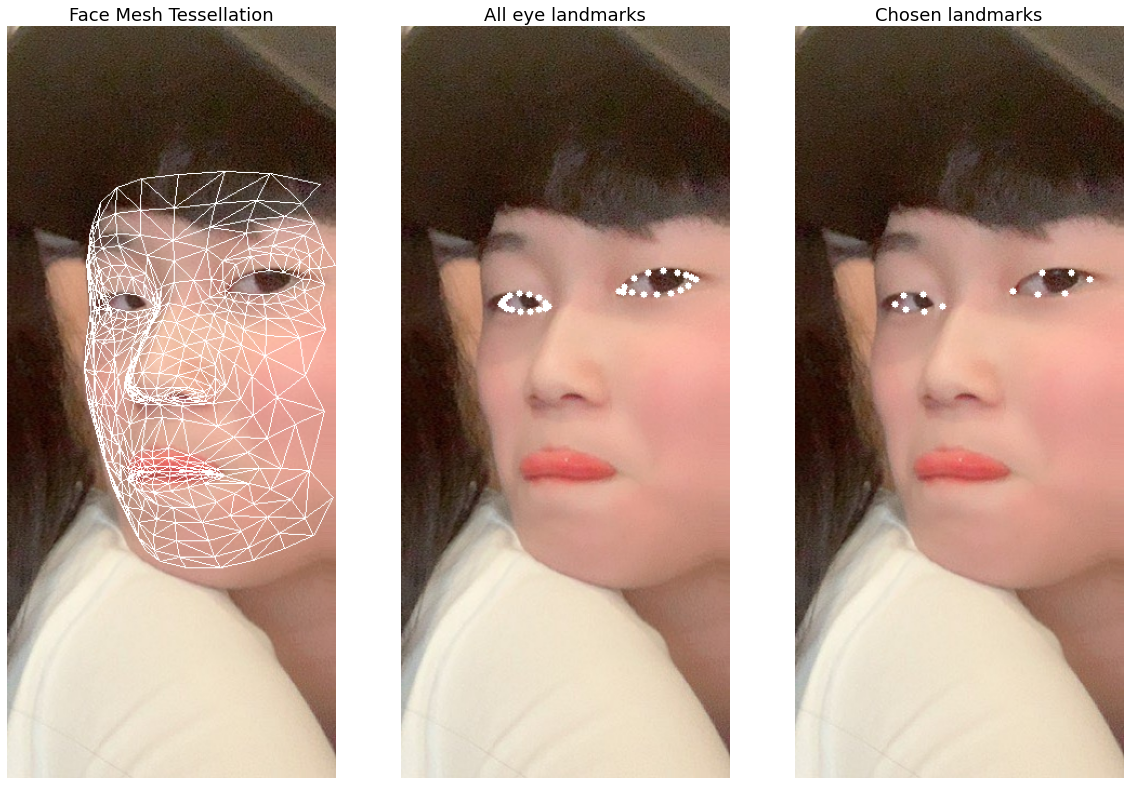

In [ ]:
# If detections are available.
if results.multi_face_landmarks:

    # Iterate over detections of each face. Here, we have max_num_faces=1,
    # So there will be at most 1 element in
    # the 'results.multi_face_landmarks' list
    # Only one iteration is performed.

    for face_id, face_landmarks in enumerate(results.multi_face_landmarks):
        _ = plot(img_dt=image.copy(), face_landmarks=face_landmarks)

In [ ]:
def distance(point_1, point_2):
    """Calculate l2-norm between two points"""
    dist = sum([(i - j) ** 2 for i, j in zip(point_1, point_2)]) ** 0.5
    return dist

In [ ]:
def get_ear(landmarks, refer_idxs, frame_width, frame_height):
    """
    Calculate Eye Aspect Ratio for one eye.

    Args:
        landmarks: (list) Detected landmarks list
        refer_idxs: (list) Index positions of the chosen landmarks
                            in order P1, P2, P3, P4, P5, P6
        frame_width: (int) Width of captured frame
        frame_height: (int) Height of captured frame

    Returns:
        ear: (float) Eye aspect ratio
    """
    try:
        # Compute the euclidean distance between the horizontal
        coords_points = []
        for i in refer_idxs:
            lm = landmarks[i]
            coord = denormalize_coordinates(lm.x, lm.y,
                                            frame_width, frame_height)
            coords_points.append(coord)

        # Eye landmark (x, y)-coordinates
        P2_P6 = distance(coords_points[1], coords_points[5])
        P3_P5 = distance(coords_points[2], coords_points[4])
        P1_P4 = distance(coords_points[0], coords_points[3])

        # Compute the eye aspect ratio
        ear = (P2_P6 + P3_P5) / (2.0 * P1_P4)

    except:
        ear = 0.0
        coords_points = None

    return ear, coords_points

In [ ]:
def calculate_avg_ear(landmarks, left_eye_idxs, right_eye_idxs, image_w, image_h):
    """Calculate Eye aspect ratio"""

    left_ear, left_lm_coordinates = get_ear(
        landmarks,
        left_eye_idxs,
        image_w,
        image_h
    )
    right_ear, right_lm_coordinates = get_ear(
        landmarks,
        right_eye_idxs,
        image_w,
        image_h
    )
    Avg_EAR = (left_ear + right_ear) / 2.0

    return left_ear, right_ear, Avg_EAR, (left_lm_coordinates, right_lm_coordinates)

In [ ]:
image_eyes_open = cv2.imread(r"test_img/test_open.jpg")[:, :, ::-1]
image_eyes_open2 = cv2.imread(r"test_img/test_group/face1.jpg")[:, :, ::-1]
image_eyes_open3 = cv2.imread(r"test_img/test_group/face2.jpg")[:, :, ::-1]
image_eyes_open4 = cv2.imread(r"test_img/test_group/face3.jpg")[:, :, ::-1]
image_eyes_open5 = cv2.imread(r"test_img/test_group/face4.jpg")[:, :, ::-1]
image_eyes_close = cv2.imread(r"test_img/test_close2.jpg")[:, :, ::-1]

for idx, image in enumerate([image_eyes_open, image_eyes_open2, image_eyes_open3, image_eyes_open4, image_eyes_open5, image_eyes_close]):

    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape

    # Creating a copy of the original image for plotting the EAR value
    custom_chosen_lmk_image = image.copy()

    # Running inference using static_image_mode
    with mp_facemesh.FaceMesh(refine_landmarks=True) as face_mesh:
        results = face_mesh.process(image).multi_face_landmarks

        # If detections are available.
        if results:
            for face_id, face_landmarks in enumerate(results):
                landmarks = face_landmarks.landmark
                left, right, EAR, _ = calculate_avg_ear(
                    landmarks,
                    chosen_left_eye_idxs,
                    chosen_right_eye_idxs,
                    imgW,
                    imgH
                )

                if left > 0.25:
                    ear_text1 = 'OPEN'
                elif left > 0.05:
                    ear_text1 = 'SMILE'
                else:
                    ear_text1 = 'CLOSE'

                if right > 0.25:
                    ear_text2 = 'OPEN'
                elif right > 0.05:
                    ear_text2 = 'SMILE'
                else:
                    ear_text2 = 'CLOSE'

                if EAR > 0.25:
                    ear_text3 = 'OPEN'
                elif EAR > 0.05:
                    ear_text3 = 'SMILE'
                else:
                    ear_text3 = 'CLOSE'

                # Print the EAR value on the custom_chosen_lmk_image.
                cv2.putText(custom_chosen_lmk_image,
                            f"LEFT: {round(left, 2)}", (1, 24),
                            cv2.FONT_HERSHEY_COMPLEX,
                            0.9, (255, 255, 255), 2
                            )

                cv2.putText(custom_chosen_lmk_image,
                            f"{ear_text1}", (1, 48),
                            cv2.FONT_HERSHEY_COMPLEX,
                            0.9, (255, 255, 255), 2
                            )

                cv2.putText(custom_chosen_lmk_image,
                            f"RIGHT: {round(right, 2)}", (1, 72),
                            cv2.FONT_HERSHEY_COMPLEX,
                            0.9, (255, 255, 255), 2
                            )

                cv2.putText(custom_chosen_lmk_image,
                            f"{ear_text2}", (1, 96),
                            cv2.FONT_HERSHEY_COMPLEX,
                            0.9, (255, 255, 255), 2
                            )

                cv2.putText(custom_chosen_lmk_image,
                            f"AVG: {round(EAR, 2)}", (1, 120),
                            cv2.FONT_HERSHEY_COMPLEX,
                            0.9, (255, 255, 255), 2
                            )

                cv2.putText(custom_chosen_lmk_image,
                            f"{ear_text3}", (1, 144),
                            cv2.FONT_HERSHEY_COMPLEX,
                            0.9, (255, 255, 255), 2
                            )

                plot(img_dt=image.copy(),
                     img_eye_lmks_chosen=custom_chosen_lmk_image,
                     face_landmarks=face_landmarks,
                     ts_thickness=1,
                     ts_circle_radius=3,
                     lmk_circle_radius=3
                     )

Output hidden; open in https://colab.research.google.com to view.

### 함수

In [ ]:
!pwd

/content/drive/MyDrive/multicampus/team_project2/eyes_project


In [ ]:
%cd ..

/content/drive/MyDrive/multicampus/team_project2


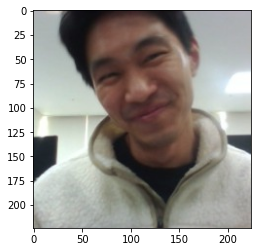

In [ ]:
# load the image
image = cv2.imread(r"wake-samples/0.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert to RGB
image = np.ascontiguousarray(image)
imgH, imgW, _ = image.shape

plt.imshow(image)

In [ ]:
def get_eyes_ear(image_path):
  global left, right, EAR

  image = cv2.imread(image_path)[:, :, ::-1]
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert to RGB
  image = np.ascontiguousarray(image)
  imgH, imgW, _ = image.shape

  chosen_left_eye_idxs = [362, 385, 387, 263, 373, 380]
  chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]

  def distance(point_1, point_2):
    dist = sum([(i - j) ** 2 for i, j in zip(point_1, point_2)]) ** 0.5
    return dist


  def get_ear(landmarks, refer_idxs, frame_width, frame_height):
    try:
        coords_points = []
        for i in refer_idxs:
            lm = landmarks[i]
            coord = denormalize_coordinates(lm.x, lm.y,
                                            frame_width, frame_height)
            coords_points.append(coord)

        P2_P6 = distance(coords_points[1], coords_points[5])
        P3_P5 = distance(coords_points[2], coords_points[4])
        P1_P4 = distance(coords_points[0], coords_points[3])

        ear = (P2_P6 + P3_P5) / (2.0 * P1_P4)

    except:
        ear = 0.0
        coords_points = None

    return ear, coords_points


  def calculate_avg_ear(landmarks, left_eye_idxs, right_eye_idxs, image_w, image_h):
    left_ear, left_lm_coordinates = get_ear(
        landmarks,
        left_eye_idxs,
        image_w,
        image_h
    )
    right_ear, right_lm_coordinates = get_ear(
        landmarks,
        right_eye_idxs,
        image_w,
        image_h
    )
    Avg_EAR = (left_ear + right_ear) / 2.0

    return left_ear, right_ear, Avg_EAR, (left_lm_coordinates, right_lm_coordinates)


  custom_chosen_lmk_image = image.copy()

  with mp_facemesh.FaceMesh(refine_landmarks=True) as face_mesh:
    results = face_mesh.process(image).multi_face_landmarks

    if results:
      for face_id, face_landmarks in enumerate(results):
          landmarks = face_landmarks.landmark
          left, right, EAR, _ = calculate_avg_ear(
              landmarks,
              chosen_left_eye_idxs,
              chosen_right_eye_idxs,
              imgW,
              imgH
          )

  return left, right, EAR

In [ ]:
import pandas as pd
df_wake = pd.DataFrame(columns=['LEFT', 'RIGHT', 'AVG'])
df_sleep = pd.DataFrame(columns=['LEFT', 'RIGHT', 'AVG'])

In [ ]:
for i in range(504):
  df_wake.loc[i] = get_eyes_ear(f"wake-samples/{i}.jpg")
for i in range(503):
  df_sleep.loc[i] = get_eyes_ear(f"sleep-samples/{i}.jpg")

In [ ]:
# sleep: 0, awake: 1
df_wake['label'] = 'wake'
df_sleep['label'] = 'sleep'

In [ ]:
df = pd.concat([df_wake, df_sleep])
df.reset_index(drop=True, inplace=True)
df.to_csv('EAR.csv', index=False)

In [ ]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
model = lg.fit(df[['LEFT', 'RIGHT', 'AVG']], df['label'])

In [ ]:
import joblib
joblib.dump(model, 'EAR_model.pkl') 

['EAR_model.pkl']

In [ ]:
predict = model.predict([list(get_eyes_ear("wake-samples/0.jpg"))])[0]
print(predict)

1


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [ ]:
model.predict([list(get_eyes_ear("eyes_project/test_img/test_open.jpg"))])[0]

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


1

In [ ]:
model.predict([list(get_eyes_ear("eyes_project/test_img/test_close.jpg"))])[0]

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


'wake'

In [ ]:
model.predict([list(get_eyes_ear("sleep-samples/401.jpg"))])[0]

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


'sleep'

In [ ]:
df_test = pd.DataFrame(columns=['LEFT', 'RIGHT', 'AVG'])

In [ ]:
test_wake = pd.DataFrame(columns=['LEFT', 'RIGHT', 'AVG'])
test_sleep = pd.DataFrame(columns=['LEFT', 'RIGHT', 'AVG'])

In [ ]:
# 각각 403개
for i in range(403):
  test_wake.loc[i] = get_eyes_ear(f"eyes_project/test_img/test/wake-samples/{i}.jpg")
  test_sleep.loc[i] = get_eyes_ear(f"eyes_project/test_img/test/sleep-samples/{i}.jpg")

In [ ]:
test_wake['label'] = 'wake'
test_sleep['label'] = 'sleep'

df_test = pd.concat([test_wake, test_sleep])
df_test.reset_index(drop=True, inplace=True)
df_test.to_csv('EAR_test.csv', index=False)

In [ ]:
df_test = df_test.sample(frac=1)
answer = df_test['label']

pred = model.predict(df_test.drop('label', axis=1))

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(answer, pred)

0.6364764267990074

In [ ]:
from sklearn.model_selection import train_test_split
data = pd.read_csv('EAR.csv')

train, test = train_test_split(data, test_size=0.3, random_state=156, stratify=data['label'])

In [ ]:
preds = model.predict(test.drop('label', axis=1))
accuracy_score(test['label'], preds)

0.8085808580858086

In [ ]:
preds = model.predict(test.drop('label', axis=1))

### pose

In [ ]:
# https://puleugo.tistory.com/17

In [1]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/multicampus/team_project2/teamproject2

/content/drive/MyDrive/multicampus/team_project2/teamproject2


In [4]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates

mp_facemesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates

%matplotlib inline

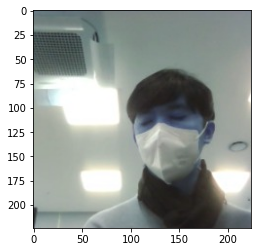

In [ ]:
image = cv2.imread('eyes_project/test_img/sleep-samples/0.jpg')[:, :, ::-1]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert to RGB
image = np.ascontiguousarray(image)
imgH, imgW, _ = image.shape

plt.imshow(image)

In [ ]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import math

In [15]:
import os
os.listdir('wake-samples3')

In [ ]:
!pwd
!ls

In [ ]:
!pwd

/content/drive/MyDrive/multicampus/team_project2/teamproject2


In [5]:
import os
# wake_list = os.listdir('wake-samples3')
# sleep_list = os.listdir('sleep-samples3')

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

# 이미지 파일의 경우 이것을 사용하세요.:
IMAGE_FILES = os.listdir('wake-samples3')
# IMAGE_FILES = ['sleep-samples3/0.jpg']
BG_COLOR = (192, 192, 192)  # 회색
with mp_pose.Pose(
        static_image_mode=True,
        model_complexity=2,
        enable_segmentation=True,
        min_detection_confidence=0.5) as pose:
    wake_landmarks = []
    for idx, files in enumerate(IMAGE_FILES):
        image = cv2.imread(f'wake-samples3/{files}')
        image_height, image_width, _ = image.shape
        # 처리 전 BGR 이미지를 RGB로 변환합니다.
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        location = []
        for landmark in results.pose_world_landmarks.landmark:
          location.append([landmark.x, landmark.y, landmark.z])
        wake_landmarks.append(np.array(location))

        if idx % 100 == 0:
          print(idx)

IMAGE_FILES = os.listdir('sleep-samples3')
# IMAGE_FILES = ['sleep-samples3/0.jpg']
BG_COLOR = (192, 192, 192)  # 회색
with mp_pose.Pose(
        static_image_mode=True,
        model_complexity=2,
        enable_segmentation=True,
        min_detection_confidence=0.5) as pose:
    sleep_landmarks = []
    for idx, files in enumerate(IMAGE_FILES):
        image = cv2.imread(f'sleep-samples3/{files}')
        image_height, image_width, _ = image.shape
        # 처리 전 BGR 이미지를 RGB로 변환합니다.
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        location = []
        for landmark in results.pose_world_landmarks.landmark:
          location.append([landmark.x, landmark.y, landmark.z])
        sleep_landmarks.append(np.array(location))

        if idx % 100 == 0:
          print(idx)

In [ ]:
wake_landmarks[0]

In [ ]:
########################################3##############
#######################################################

Nose coordinates: (102.7235460281372, 120.32238006591797)


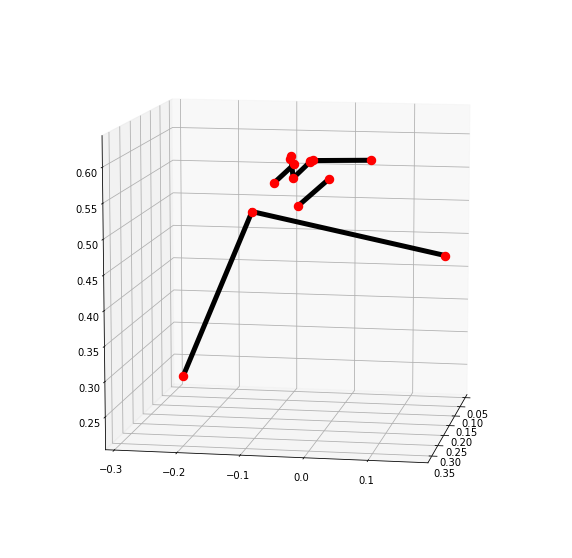

In [91]:
with mp_pose.Pose(
        static_image_mode=True,
        model_complexity=2,
        enable_segmentation=True,
        min_detection_confidence=0.5) as pose:
    for idx, file in enumerate(['wake-samples3/500.jpg']):
        image = cv2.imread(file)
        image_height, image_width, _ = image.shape
        # 처리 전 BGR 이미지를 RGB로 변환합니다.
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if not results.pose_landmarks:
            continue
        print(
            f'Nose coordinates: ('
            f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width}, '
            f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_height})'
        )

        annotated_image = image.copy()
        # 이미지를 분할합니다.
        # 경계 주변의 분할을 개선하려면 "image"가 있는
        # "results.segmentation_mask"에 공동 양방향 필터를 적용하는 것이 좋습니다.
        condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
        bg_image = np.zeros(image.shape, dtype=np.uint8)
        bg_image[:] = BG_COLOR
        annotated_image = np.where(condition, annotated_image, bg_image)
        # 이미지 위에 포즈 랜드마크를 그립니다.
        mp_drawing.draw_landmarks(
            annotated_image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        cv2.imwrite('/tmp/annotated_image' +
                    str(idx) + '.png', annotated_image)
        # 포즈 월드 랜드마크를 그립니다.
        mp_drawing.plot_landmarks(
            results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
            # results.pose_world_landmarks.landmark[:12], mp_pose.POSE_CONNECTIONS)

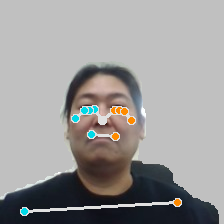

In [92]:
from google.colab.patches import cv2_imshow
cv2_imshow(annotated_image)

In [ ]:
# mp_drawing.plot_landmarks(
#             results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
results.pose_world_landmarks.landmark[:12]

In [5]:
import time
import math

def findDistance(x1, y1, x2, y2):
  dist = math.sqrt((x2-x1)**2+(y2-y1)**2)
  return dist
def findAngle(x1, y1, x2, y2):
  theta = math.acos((y2-y1)*(-y1) / (math.sqrt((x2-x1)**2+(y2-y1)**2)*y1))
  degree = int(180/math.pi) * theta
  return degree

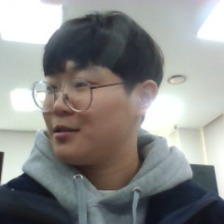

In [7]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

image = cv2.imread('wake-samples3/1014.jpg')
# image = cv2.imread('sleep-samples3/1180.jpg')
h, w = image.shape[:2]

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

keypoints = pose.process(image)

image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

lm = keypoints.pose_landmarks
lmPose = mp_pose.PoseLandmark

## 어깨 ##
# 왼쪽 어깨
l_shldr_x = int(lm.landmark[lmPose.LEFT_SHOULDER].x*w)
l_shldr_y = int(lm.landmark[lmPose.LEFT_SHOULDER].y*w)
# 오른쪽 어깨
r_shldr_x = int(lm.landmark[lmPose.RIGHT_SHOULDER].x*w)
r_shldr_y = int(lm.landmark[lmPose.RIGHT_SHOULDER].y*w)

## 눈 ##
# 왼쪽 눈
l_eye_x = int(lm.landmark[lmPose.LEFT_EYE].x*w)
l_eye_y = int(lm.landmark[lmPose.LEFT_EYE].y*w)
# 오른쪽 눈
r_eye_x = int(lm.landmark[lmPose.RIGHT_EYE].x*w)
r_eye_y = int(lm.landmark[lmPose.RIGHT_EYE].y*w)

cv2_imshow(image)

In [9]:
print(findDistance(l_shldr_x, l_shldr_y, l_eye_x, l_eye_y))
print(findDistance(r_shldr_x, r_shldr_y, r_eye_x, r_eye_y))

146.0
98.2700361249552


In [10]:
print(findAngle(l_shldr_x, l_shldr_y, l_eye_x, l_eye_y))
print(findAngle(r_shldr_x, r_shldr_y, r_eye_x, r_eye_y))

48.635534216463874
12.275388882771052


In [11]:
findAngle(l_eye_x, l_eye_y, r_eye_x, r_eye_y)

83.85427743531288

In [14]:
get_eyes_ear('wake-samples3/1014.jpg')

('wake', 0.24135404574916758, 0.4581228472908512)

In [ ]:
def eyeShoulderDistance

In [6]:
def eyesAngle(image_path):
  mp_pose = mp.solutions.pose
  pose = mp_pose.Pose()

  image = cv2.imread(image_path)
  h, w = image.shape[:2]

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  keypoints = pose.process(image)

  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

  lm = keypoints.pose_landmarks
  lmPose = mp_pose.PoseLandmark

  x1 = int(lm.landmark[lmPose.LEFT_EYE].x*w)  # 왼쪽 눈 x좌표
  y1 = int(lm.landmark[lmPose.LEFT_EYE].y*w)  # 왼쪽 눈 y좌표
  x2 = int(lm.landmark[lmPose.RIGHT_EYE].x*w)  # 오른쪽 눈 x좌표
  y2 = int(lm.landmark[lmPose.RIGHT_EYE].y*w)  # 오른쪽 눈 y좌표

  theta = math.acos((y2-y1)*(-y1) / (math.sqrt((x2-x1)**2+(y2-y1)**2)*y1))
  degree = int(180/math.pi) * theta

  return degree

In [13]:
def get_eyes_ear(image_path):
  global left, right, AVG

  image = cv2.imread(image_path)[:, :, ::-1]
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert to RGB
  image = np.ascontiguousarray(image)
  imgH, imgW, _ = image.shape

  chosen_left_eye_idxs = [362, 385, 387, 263, 373, 380]
  chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]

  def distance(point_1, point_2):
    dist = sum([(i - j) ** 2 for i, j in zip(point_1, point_2)]) ** 0.5
    return dist


  def get_ear(landmarks, refer_idxs, frame_width, frame_height):
    try:
        coords_points = []
        for i in refer_idxs:
            lm = landmarks[i]
            coord = denormalize_coordinates(lm.x, lm.y,
                                            frame_width, frame_height)
            coords_points.append(coord)

        P2_P6 = distance(coords_points[1], coords_points[5])
        P3_P5 = distance(coords_points[2], coords_points[4])
        P1_P4 = distance(coords_points[0], coords_points[3])

        ear = (P2_P6 + P3_P5) / (2.0 * P1_P4)

    except:
        ear = 0.0
        coords_points = None

    return ear, coords_points


  def calculate_avg_ear(landmarks, left_eye_idxs, right_eye_idxs, image_w, image_h):
    left_ear, left_lm_coordinates = get_ear(
        landmarks,
        left_eye_idxs,
        image_w,
        image_h
    )
    right_ear, right_lm_coordinates = get_ear(
        landmarks,
        right_eye_idxs,
        image_w,
        image_h
    )
    Avg_EAR = (left_ear + right_ear) / 2.0

    return left_ear, right_ear, Avg_EAR, (left_lm_coordinates, right_lm_coordinates)


  custom_chosen_lmk_image = image.copy()

  with mp_facemesh.FaceMesh(refine_landmarks=True) as face_mesh:
    results = face_mesh.process(image).multi_face_landmarks

    if results:
      for face_id, face_landmarks in enumerate(results):
          landmarks = face_landmarks.landmark
          left, right, AVG, _ = calculate_avg_ear(
              landmarks,
              chosen_left_eye_idxs,
              chosen_right_eye_idxs,
              imgW,
              imgH
          )

    if max(left, right, AVG) > 0.2:
      answer = 'wake'
    else:
      answer = 'sleep'
  return answer, left, right
  # return left, right

In [137]:
cnt = 0
tmp = []
for image in os.listdir('wake-samples3'):
  if get_eyes_ear(f'wake-samples3/{image}') == 'sleep':
    cnt += 1
    tmp.append(image)
print(cnt)
print(tmp)

135
['679.jpg', '88.jpg', '86.jpg', '1027.jpg', '127.jpg', '129.jpg', '168.jpg', '1147.jpg', '933.jpg', '80.jpg', '90.jpg', '16.jpg', '1105.jpg', '1097.jpg', '1100.jpg', '188.jpg', '1048.jpg', '1026.jpg', '744.jpg', '162.jpg', '889.jpg', '126.jpg', '187.jpg', '83.jpg', '124.jpg', '1198.jpg', '1025.jpg', '1068.jpg', '1183.jpg', '1175.jpg', '85.jpg', '178.jpg', '70.jpg', '1018.jpg', '1176.jpg', '89.jpg', '531.jpg', '20.jpg', '1103.jpg', '706.jpg', '985.jpg', '1099.jpg', '1102.jpg', '993.jpg', '345.jpg', '19.jpg', '1098.jpg', '87.jpg', '778.jpg', '1108.jpg', '14.jpg', '1181.jpg', '1024.jpg', '937.jpg', '1101.jpg', '134.jpg', '1017.jpg', '1022.jpg', '135.jpg', '707.jpg', '1071.jpg', '934.jpg', '170.jpg', '515.jpg', '535.jpg', '196.jpg', '1069.jpg', '1016.jpg', '1110.jpg', '82.jpg', '1002.jpg', '1095.jpg', '1094.jpg', '1021.jpg', '829.jpg', '1111.jpg', '1067.jpg', '383.jpg', '23.jpg', '858.jpg', '678.jpg', '1197.jpg', '753.jpg', '618.jpg', '191.jpg', '1072.jpg', '192.jpg', '982.jpg', '1104.

In [138]:
cnt = 0
for image in os.listdir('sleep-samples3'):
  if get_eyes_ear(f'sleep-samples3/{image}') == 'wake':
    cnt += 1
    tmp.append(image)
print(cnt)
print(tmp)

214
['679.jpg', '88.jpg', '86.jpg', '1027.jpg', '127.jpg', '129.jpg', '168.jpg', '1147.jpg', '933.jpg', '80.jpg', '90.jpg', '16.jpg', '1105.jpg', '1097.jpg', '1100.jpg', '188.jpg', '1048.jpg', '1026.jpg', '744.jpg', '162.jpg', '889.jpg', '126.jpg', '187.jpg', '83.jpg', '124.jpg', '1198.jpg', '1025.jpg', '1068.jpg', '1183.jpg', '1175.jpg', '85.jpg', '178.jpg', '70.jpg', '1018.jpg', '1176.jpg', '89.jpg', '531.jpg', '20.jpg', '1103.jpg', '706.jpg', '985.jpg', '1099.jpg', '1102.jpg', '993.jpg', '345.jpg', '19.jpg', '1098.jpg', '87.jpg', '778.jpg', '1108.jpg', '14.jpg', '1181.jpg', '1024.jpg', '937.jpg', '1101.jpg', '134.jpg', '1017.jpg', '1022.jpg', '135.jpg', '707.jpg', '1071.jpg', '934.jpg', '170.jpg', '515.jpg', '535.jpg', '196.jpg', '1069.jpg', '1016.jpg', '1110.jpg', '82.jpg', '1002.jpg', '1095.jpg', '1094.jpg', '1021.jpg', '829.jpg', '1111.jpg', '1067.jpg', '383.jpg', '23.jpg', '858.jpg', '678.jpg', '1197.jpg', '753.jpg', '618.jpg', '191.jpg', '1072.jpg', '192.jpg', '982.jpg', '1104.

In [145]:
print(tmp[135:])

['702.jpg', '258.jpg', '41.jpg', '700.jpg', '141.jpg', '27.jpg', '110.jpg', '312.jpg', '392.jpg', '145.jpg', '340.jpg', '45.jpg', '90.jpg', '119.jpg', '291.jpg', '51.jpg', '232.jpg', '84.jpg', '29.jpg', '334.jpg', '150.jpg', '909.jpg', '120.jpg', '352.jpg', '274.jpg', '1065.jpg', '117.jpg', '147.jpg', '96.jpg', '118.jpg', '877.jpg', '226.jpg', '148.jpg', '1068.jpg', '167.jpg', '89.jpg', '351.jpg', '857.jpg', '695.jpg', '47.jpg', '35.jpg', '323.jpg', '179.jpg', '207.jpg', '1006.jpg', '1029.jpg', '321.jpg', '115.jpg', '693.jpg', '144.jpg', '1183.jpg', '890.jpg', '1114.jpg', '197.jpg', '366.jpg', '374.jpg', '195.jpg', '318.jpg', '269.jpg', '146.jpg', '135.jpg', '922.jpg', '138.jpg', '200.jpg', '113.jpg', '52.jpg', '159.jpg', '822.jpg', '280.jpg', '37.jpg', '33.jpg', '256.jpg', '914.jpg', '210.jpg', '747.jpg', '1171.jpg', '95.jpg', '992.jpg', '628.jpg', '281.jpg', '34.jpg', '694.jpg', '102.jpg', '39.jpg', '142.jpg', '1178.jpg', '88.jpg', '698.jpg', '257.jpg', '38.jpg', '1117.jpg', '1010.jp

In [146]:
get_eyes_ear('sleep-samples3/702.jpg')

('wake', 0.20701710508942092, 0.09633760902169114)

In [151]:
eyesAngle('wake-samples3/1014.jpg')

83.85427743531288

In [7]:
wake_error = ['679.jpg', '88.jpg', '86.jpg', '1027.jpg', '127.jpg', '129.jpg', '168.jpg', '1147.jpg', '933.jpg', '80.jpg', '90.jpg', '16.jpg', '1105.jpg', '1097.jpg', '1100.jpg', '188.jpg', '1048.jpg', '1026.jpg', '744.jpg', '162.jpg', '889.jpg', '126.jpg', '187.jpg', '83.jpg', '124.jpg', '1198.jpg', '1025.jpg', '1068.jpg', '1183.jpg', '1175.jpg', '85.jpg', '178.jpg', '70.jpg', '1018.jpg', '1176.jpg', '89.jpg', '531.jpg', '20.jpg', '1103.jpg', '706.jpg', '985.jpg', '1099.jpg', '1102.jpg', '993.jpg', '345.jpg', '19.jpg', '1098.jpg', '87.jpg', '778.jpg', '1108.jpg', '14.jpg', '1181.jpg', '1024.jpg', '937.jpg', '1101.jpg', '134.jpg', '1017.jpg', '1022.jpg', '135.jpg', '707.jpg', '1071.jpg', '934.jpg', '170.jpg', '515.jpg', '535.jpg', '196.jpg', '1069.jpg', '1016.jpg', '1110.jpg', '82.jpg', '1002.jpg', '1095.jpg', '1094.jpg', '1021.jpg', '829.jpg', '1111.jpg', '1067.jpg', '383.jpg', '23.jpg', '858.jpg', '678.jpg', '1197.jpg', '753.jpg', '618.jpg', '191.jpg', '1072.jpg', '192.jpg', '982.jpg', '1104.jpg', '606.jpg', '1020.jpg', '732.jpg', '1145.jpg', '189.jpg', '133.jpg', '125.jpg', '99.jpg', '534.jpg', '194.jpg', '1112.jpg', '1141.jpg', '456.jpg', '43.jpg', '1127.jpg', '130.jpg', '193.jpg', '573.jpg', '65.jpg', '994.jpg', '628.jpg', '1109.jpg', '91.jpg', '69.jpg', '1140.jpg', '514.jpg', '1146.jpg', '1023.jpg', '128.jpg', '571.jpg', '743.jpg', '186.jpg', '177.jpg', '935.jpg', '116.jpg', '1070.jpg', '1001.jpg', '1003.jpg', '572.jpg', '132.jpg', '346.jpg', '337.jpg', '119.jpg', '71.jpg', '169.jpg', '115.jpg']
sleep_error = ['702.jpg', '258.jpg', '41.jpg', '700.jpg', '141.jpg', '27.jpg', '110.jpg', '312.jpg', '392.jpg', '145.jpg', '340.jpg', '45.jpg', '90.jpg', '119.jpg', '291.jpg', '51.jpg', '232.jpg', '84.jpg', '29.jpg', '334.jpg', '150.jpg', '909.jpg', '120.jpg', '352.jpg', '274.jpg', '1065.jpg', '117.jpg', '147.jpg', '96.jpg', '118.jpg', '877.jpg', '226.jpg', '148.jpg', '1068.jpg', '167.jpg', '89.jpg', '351.jpg', '857.jpg', '695.jpg', '47.jpg', '35.jpg', '323.jpg', '179.jpg', '207.jpg', '1006.jpg', '1029.jpg', '321.jpg', '115.jpg', '693.jpg', '144.jpg', '1183.jpg', '890.jpg', '1114.jpg', '197.jpg', '366.jpg', '374.jpg', '195.jpg', '318.jpg', '269.jpg', '146.jpg', '135.jpg', '922.jpg', '138.jpg', '200.jpg', '113.jpg', '52.jpg', '159.jpg', '822.jpg', '280.jpg', '37.jpg', '33.jpg', '256.jpg', '914.jpg', '210.jpg', '747.jpg', '1171.jpg', '95.jpg', '992.jpg', '628.jpg', '281.jpg', '34.jpg', '694.jpg', '102.jpg', '39.jpg', '142.jpg', '1178.jpg', '88.jpg', '698.jpg', '257.jpg', '38.jpg', '1117.jpg', '1010.jpg', '136.jpg', '751.jpg', '696.jpg', '134.jpg', '749.jpg', '101.jpg', '86.jpg', '209.jpg', '1103.jpg', '137.jpg', '818.jpg', '171.jpg', '607.jpg', '927.jpg', '220.jpg', '819.jpg', '384.jpg', '1031.jpg', '350.jpg', '91.jpg', '1165.jpg', '98.jpg', '847.jpg', '70.jpg', '46.jpg', '116.jpg', '1082.jpg', '234.jpg', '1100.jpg', '298.jpg', '177.jpg', '1107.jpg', '140.jpg', '972.jpg', '758.jpg', '1167.jpg', '166.jpg', '125.jpg', '1040.jpg', '916.jpg', '255.jpg', '348.jpg', '1009.jpg', '57.jpg', '601.jpg', '821.jpg', '48.jpg', '746.jpg', '941.jpg', '1056.jpg', '42.jpg', '381.jpg', '253.jpg', '173.jpg', '139.jpg', '254.jpg', '0.jpg', '940.jpg', '354.jpg', '993.jpg', '294.jpg', '1027.jpg', '938.jpg', '165.jpg', '1032.jpg', '30.jpg', '1033.jpg', '97.jpg', '94.jpg', '270.jpg', '156.jpg', '178.jpg', '111.jpg', '333.jpg', '915.jpg', '99.jpg', '697.jpg', '1111.jpg', '373.jpg', '1182.jpg', '353.jpg', '93.jpg', '884.jpg', '1046.jpg', '5.jpg', '944.jpg', '1044.jpg', '606.jpg', '1168.jpg', '49.jpg', '1055.jpg', '92.jpg', '180.jpg', '957.jpg', '155.jpg', '143.jpg', '114.jpg', '1118.jpg', '87.jpg', '172.jpg', '699.jpg', '85.jpg', '174.jpg', '112.jpg', '40.jpg', '997.jpg', '296.jpg', '1064.jpg', '201.jpg', '315.jpg', '371.jpg', '43.jpg', '937.jpg', '182.jpg', '920.jpg', '164.jpg', '399.jpg', '701.jpg', '265.jpg', '252.jpg', '356.jpg', '105.jpg']

In [16]:
cnt = 0
tmp = []
for image in wake_error:
  if 80 < eyesAngle(f'wake-samples3/{image}') < 100:
    pass
  else:
    cnt += 1
    tmp.append(image)
print(cnt)
print(tmp)

38
['88.jpg', '86.jpg', '127.jpg', '168.jpg', '16.jpg', '188.jpg', '162.jpg', '126.jpg', '83.jpg', '124.jpg', '85.jpg', '178.jpg', '70.jpg', '89.jpg', '20.jpg', '19.jpg', '87.jpg', '14.jpg', '134.jpg', '170.jpg', '196.jpg', '383.jpg', '191.jpg', '192.jpg', '189.jpg', '133.jpg', '125.jpg', '99.jpg', '194.jpg', '193.jpg', '65.jpg', '186.jpg', '177.jpg', '132.jpg', '119.jpg', '71.jpg', '169.jpg', '115.jpg']


In [31]:
sorted(tmp, key=lambda x: int(x.split('.')[0]))  # 0-199 삭제

['14.jpg',
 '16.jpg',
 '19.jpg',
 '20.jpg',
 '65.jpg',
 '70.jpg',
 '71.jpg',
 '83.jpg',
 '85.jpg',
 '86.jpg',
 '87.jpg',
 '88.jpg',
 '89.jpg',
 '99.jpg',
 '115.jpg',
 '119.jpg',
 '124.jpg',
 '125.jpg',
 '126.jpg',
 '127.jpg',
 '132.jpg',
 '133.jpg',
 '134.jpg',
 '162.jpg',
 '168.jpg',
 '169.jpg',
 '170.jpg',
 '177.jpg',
 '178.jpg',
 '186.jpg',
 '188.jpg',
 '189.jpg',
 '191.jpg',
 '192.jpg',
 '193.jpg',
 '194.jpg',
 '196.jpg',
 '383.jpg']

In [8]:
cnt = 0
tmp = []
for image in sleep_error:
  if 80 < eyesAngle(f'sleep-samples3/{image}') < 100:
    cnt += 1
    tmp.append(image)
print(cnt)
print(tmp)

98
['258.jpg', '312.jpg', '392.jpg', '340.jpg', '291.jpg', '232.jpg', '84.jpg', '334.jpg', '909.jpg', '352.jpg', '274.jpg', '1065.jpg', '877.jpg', '226.jpg', '1068.jpg', '351.jpg', '857.jpg', '323.jpg', '207.jpg', '1029.jpg', '321.jpg', '693.jpg', '1183.jpg', '890.jpg', '1114.jpg', '197.jpg', '366.jpg', '374.jpg', '318.jpg', '269.jpg', '922.jpg', '200.jpg', '280.jpg', '256.jpg', '210.jpg', '1171.jpg', '992.jpg', '628.jpg', '281.jpg', '1178.jpg', '257.jpg', '1117.jpg', '134.jpg', '209.jpg', '1103.jpg', '137.jpg', '927.jpg', '220.jpg', '384.jpg', '1031.jpg', '350.jpg', '1165.jpg', '847.jpg', '1082.jpg', '234.jpg', '1100.jpg', '298.jpg', '1107.jpg', '972.jpg', '1167.jpg', '1040.jpg', '255.jpg', '348.jpg', '1056.jpg', '381.jpg', '253.jpg', '254.jpg', '354.jpg', '993.jpg', '294.jpg', '1027.jpg', '1032.jpg', '1033.jpg', '270.jpg', '333.jpg', '1111.jpg', '373.jpg', '1182.jpg', '353.jpg', '884.jpg', '1046.jpg', '1044.jpg', '1168.jpg', '1055.jpg', '957.jpg', '1118.jpg', '997.jpg', '296.jpg', '1

In [9]:
sorted(tmp, key=lambda x: int(x.split('.')[0]))  # 200-399 삭제

['84.jpg',
 '134.jpg',
 '137.jpg',
 '182.jpg',
 '197.jpg',
 '200.jpg',
 '201.jpg',
 '207.jpg',
 '209.jpg',
 '210.jpg',
 '220.jpg',
 '226.jpg',
 '232.jpg',
 '234.jpg',
 '252.jpg',
 '253.jpg',
 '254.jpg',
 '255.jpg',
 '256.jpg',
 '257.jpg',
 '258.jpg',
 '265.jpg',
 '269.jpg',
 '270.jpg',
 '274.jpg',
 '280.jpg',
 '281.jpg',
 '291.jpg',
 '294.jpg',
 '296.jpg',
 '298.jpg',
 '312.jpg',
 '315.jpg',
 '318.jpg',
 '321.jpg',
 '323.jpg',
 '333.jpg',
 '334.jpg',
 '340.jpg',
 '348.jpg',
 '350.jpg',
 '351.jpg',
 '352.jpg',
 '353.jpg',
 '354.jpg',
 '356.jpg',
 '366.jpg',
 '371.jpg',
 '373.jpg',
 '374.jpg',
 '381.jpg',
 '384.jpg',
 '392.jpg',
 '399.jpg',
 '628.jpg',
 '693.jpg',
 '847.jpg',
 '857.jpg',
 '877.jpg',
 '884.jpg',
 '890.jpg',
 '909.jpg',
 '920.jpg',
 '922.jpg',
 '927.jpg',
 '957.jpg',
 '972.jpg',
 '992.jpg',
 '993.jpg',
 '997.jpg',
 '1027.jpg',
 '1029.jpg',
 '1031.jpg',
 '1032.jpg',
 '1033.jpg',
 '1040.jpg',
 '1044.jpg',
 '1046.jpg',
 '1055.jpg',
 '1056.jpg',
 '1064.jpg',
 '1065.jpg',
 '106

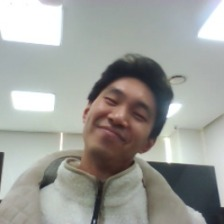

In [27]:
eyesAngle('wake-samples3/127.jpg')
image = cv2.imread('wake-samples3/127.jpg')
cv2_imshow(image)

In [18]:
!pwd

/content/drive/MyDrive/multicampus/team_project2/teamproject2


In [10]:
# wake: 0, sleep: 1
wake_labels = np.zeros(shape=(1202,))
sleep_labels = np.ones(shape=(1202,))

In [12]:
print(f'wake_landmarks {np.array(wake_landmarks).shape}, wake_labels {wake_labels.shape}')
print(f'sleep_landmarks {np.array(sleep_landmarks).shape}, sleep_labels {sleep_labels.shape}')

wake_landmarks (1202, 33, 3), wake_labels (1202,)
sleep_landmarks (1202, 33, 3), sleep_labels (1202,)


In [18]:
pose_landmarks = np.vstack((np.array(wake_landmarks), np.array(sleep_landmarks)))
pose_labels = np.hstack((wake_labels, sleep_labels))

In [19]:
print(f'pose_landmarks {pose_landmarks.shape}, pose_labels {pose_labels.shape}')

pose_landmarks (2404, 33, 3), pose_labels (2404,)


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pose_landmarks, pose_labels, test_size=0.2, random_state=156)

In [28]:
X_train = X_train.reshape((1923, 33, 3, 1))
X_test = X_test.reshape((481, 33, 3, 1))

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [45]:
model = Sequential()

In [46]:
model.add(Conv2D(32, (3, 2), padding='valid', input_shape=(33, 3, 1), activation='relu'))

In [47]:
model.add(layers.Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 

In [48]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

In [49]:
model.fit(X_train, y_train, epochs=10, batch_size=5)

Epoch 1/10
385/385 [==============================] - 2s 3ms/step - loss: 0.6556 - accuracy: 0.5933
Epoch 2/10
385/385 [==============================] - 1s 3ms/step - loss: 0.5184 - accuracy: 0.7285
Epoch 3/10
385/385 [==============================] - 1s 3ms/step - loss: 0.4818 - accuracy: 0.7535
Epoch 4/10
385/385 [==============================] - 1s 3ms/step - loss: 0.4686 - accuracy: 0.7676
Epoch 5/10
385/385 [==============================] - 1s 3ms/step - loss: 0.4390 - accuracy: 0.7738
Epoch 6/10
385/385 [==============================] - 1s 3ms/step - loss: 0.4585 - accuracy: 0.7520
Epoch 7/10
385/385 [==============================] - 1s 3ms/step - loss: 0.4090 - accuracy: 0.7925
Epoch 8/10
385/385 [==============================] - 1s 3ms/step - loss: 0.4026 - accuracy: 0.8071
Epoch 9/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3910 - accuracy: 0.8154
Epoch 10/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3812 - accuracy: 0.8112

In [50]:
model.evaluate(X_test, y_test)  # [0.3510306179523468, 0.8274428248405457]

16/16 [==============================] - 0s 3ms/step - loss: 0.3510 - accuracy: 0.8274


[0.3510306179523468, 0.8274428248405457]

In [51]:
wake_landmarks[0]
# X_train = X_train.reshape((1923, 33, 3, 1))

# model.predict()

array([[-0.01035538, -0.56644922, -0.34690186],
       [ 0.00301214, -0.59060103, -0.33542004],
       [ 0.00528864, -0.59040654, -0.32395422],
       [ 0.00221932, -0.59100962, -0.32734171],
       [-0.02084232, -0.59753871, -0.35291132],
       [-0.01776745, -0.59504586, -0.36718869],
       [-0.01676418, -0.58478814, -0.34835523],
       [ 0.04912543, -0.58776593, -0.21713074],
       [-0.0982751 , -0.54226846, -0.24409601],
       [ 0.02414653, -0.56029171, -0.29136777],
       [-0.01541975, -0.52444416, -0.32405469],
       [ 0.14275858, -0.43251616, -0.07999667],
       [-0.1709287 , -0.46918043, -0.06959493],
       [ 0.22337684, -0.26250798, -0.10090949],
       [-0.18992954, -0.19256881, -0.10322551],
       [ 0.21244678, -0.08320667, -0.10967746],
       [-0.20205051, -0.02301514, -0.1659012 ],
       [ 0.20614371, -0.04947299, -0.11926405],
       [-0.17818817,  0.00483563, -0.19122407],
       [ 0.17018199, -0.05361037, -0.12589915],
       [-0.15556327, -0.02997665, -0.210

In [ ]:
# # 3. 합성곱 신경망 구성하기
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

# model.summary()

In [ ]:
import os
os.listdir('TeamA_name')

train = [x for x in os.listdir('TeamA_name') if 'train' in x]
test = [x for x in os.listdir('TeamA_name') if 'test' in x]

hyeon = [x for x in os.listdir('TeamA_name') if x.startswith('hyeon')]
others = [x for x in os.listdir('TeamA_name') if not x.startswith('hyeon')]

xtrain = []
ytrain = []
for f in train:
    img = image.load_img(f'TeamA_name/{f}')
    img_tensor = image.img_to_array(img)
    xtrain.append(img_tensor)
    ytrain.append(1 if f in hyeon else 0)
xtrain = np.array(xtrain)
ytrain = np.array(ytrain)

xtest = []
ytest = []
for f in test:
    img = image.load_img(f'TeamA_name/{f}')
    img_tensor = image.img_to_array(img)
    xtest.append(img_tensor)
    ytest.append(1 if f in hyeon else 0)
xtest = np.array(xtest)
ytest = np.array(ytest)

model = Sequential()

model.add(Conv2D(32, (5, 5), padding='valid', input_shape=(30, 60, 3), activation='relu'))

model.add(layers.Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

model.fit(xtrain, ytrain, epochs=10, batch_size=5)

model.evaluate(xtest, ytest)  # [0.10120024532079697, 0.949999988079071]

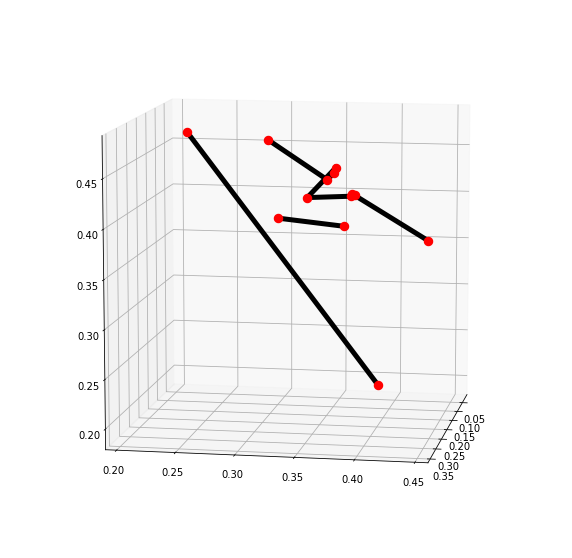

In [ ]:
tmp = mp_drawing.plot_landmarks(
            results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

In [ ]:
condition

array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [False, False, False],
        [False, False, False],
        [False,

In [ ]:
location = []
for landmark in results.pose_world_landmarks.landmark:
  location.append([landmark.x, landmark.y, landmark.z])
np.array(location).shape

(33, 3)

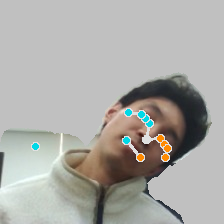

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(annotated_image)

In [120]:
def get_eyes_ear(image_path):
  global left, right, EAR

  image = cv2.imread(image_path)[:, :, ::-1]
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert to RGB
  image = np.ascontiguousarray(image)
  imgH, imgW, _ = image.shape

  chosen_left_eye_idxs = [362, 385, 387, 263, 373, 380]
  chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]

  def distance(point_1, point_2):
    dist = sum([(i - j) ** 2 for i, j in zip(point_1, point_2)]) ** 0.5
    return dist


  def get_ear(landmarks, refer_idxs, frame_width, frame_height):
    try:
        coords_points = []
        for i in refer_idxs:
            lm = landmarks[i]
            coord = denormalize_coordinates(lm.x, lm.y,
                                            frame_width, frame_height)
            coords_points.append(coord)

        P2_P6 = distance(coords_points[1], coords_points[5])
        P3_P5 = distance(coords_points[2], coords_points[4])
        P1_P4 = distance(coords_points[0], coords_points[3])

        ear = (P2_P6 + P3_P5) / (2.0 * P1_P4)

    except:
        ear = 0.0
        coords_points = None

    return ear, coords_points


  def calculate_avg_ear(landmarks, left_eye_idxs, right_eye_idxs, image_w, image_h):
    left_ear, left_lm_coordinates = get_ear(
        landmarks,
        left_eye_idxs,
        image_w,
        image_h
    )
    right_ear, right_lm_coordinates = get_ear(
        landmarks,
        right_eye_idxs,
        image_w,
        image_h
    )
    Avg_EAR = (left_ear + right_ear) / 2.0

    return left_ear, right_ear, Avg_EAR, (left_lm_coordinates, right_lm_coordinates)


  custom_chosen_lmk_image = image.copy()

  with mp_facemesh.FaceMesh(refine_landmarks=True) as face_mesh:
    results = face_mesh.process(image).multi_face_landmarks

    if results:
      for face_id, face_landmarks in enumerate(results):
          landmarks = face_landmarks.landmark
          left, right, AVG, _ = calculate_avg_ear(
              landmarks,
              chosen_left_eye_idxs,
              chosen_right_eye_idxs,
              imgW,
              imgH
          )

    if AVG > 0.25:
      answer = 'wake'
    else:
      answer = 'sleep'
  return answer
  # return left, right

In [ ]:
def get_pose_distance(image_path):

  image = cv2.imread(image_path)
  
  pose_image = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)
  left_ear = pose_image.process(image).pose_landmarks.landmark[7]
  left_shoulder = pose_image.process(image).pose_landmarks.landmark[11]
  right_ear = pose_image.process(image).pose_landmarks.landmark[8]
  right_shoulder = pose_image.process(image).pose_landmarks.landmark[12]

  dist3D = lambda a, b: math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2)



  left_dist = dist3D((left_ear.x, left_ear.y, left_ear.z), (left_shoulder.x, left_shoulder.y, left_shoulder.z))
  right_dist = dist3D((right_ear.x, right_ear.y, right_ear.z), (right_shoulder.x, right_shoulder.y, right_shoulder.z))

  return left_dist, right_dist

In [ ]:
get_pose_distance('eyes_project/test_img/sleep-samples/0.jpg')

(0.46151026452299176, 0.5619547816587053)

In [ ]:
get_eyes_ear('eyes_project/test_img/sleep-samples/0.jpg')

(0.10587026825995569, 0.1419109685344435)

In [ ]:
!pwd

/content/drive/MyDrive/multicampus/team_project2


In [ ]:
%cd teamproject2

/content/drive/MyDrive/multicampus/team_project2/teamproject2


In [ ]:
# !unzip -qq "data/wake-samples3.zip"
# !unzip -qq "data/sleep-samples3.zip"

replace 0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace 0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace 0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import pandas as pd
ear_wake = pd.DataFrame(columns=['EAR_LEFT', 'EAR_RIGHT'])
ear_sleep = pd.DataFrame(columns=['EAR_LEFT', 'EAR_RIGHT'])

In [ ]:
pose_wake = pd.DataFrame(columns=['POSE_LEFT', 'POS_RIGHT'])
pose_sleep = pd.DataFrame(columns=['POSE_LEFT', 'POS_RIGHT'])

In [ ]:
for i in range(1202):
  ear_wake.loc[i] = get_eyes_ear(f"wake-samples3/{i}.jpg")
  ear_sleep.loc[i] = get_eyes_ear(f"sleep-samples3/{i}.jpg")
  pose_wake.loc[i] = get_pose_distance(f"wake-samples3/{i}.jpg")
  pose_sleep.loc[i] = get_pose_distance(f"sleep-samples3/{i}.jpg")

AttributeError: ignored

In [ ]:
pose_sleep.shape

(44, 2)

In [ ]:
# sleep: 0, awake: 1
ear_wake['label'] = 'wake'
ear_sleep['label'] = 'sleep'
pose_wake['label'] = 'wake'
pose_sleep['label'] = 'sleep'

In [ ]:
df = pd.concat([df_wake, df_sleep])
df.reset_index(drop=True, inplace=True)
df.to_csv('EAR.csv', index=False)

In [ ]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
model = lg.fit(df[['LEFT', 'RIGHT', 'AVG']], df['label'])

In [ ]:
import joblib
joblib.dump(model, 'EAR_model.pkl') 

['EAR_model.pkl']

In [ ]:
predict = model.predict([list(get_eyes_ear("wake-samples/0.jpg"))])[0]
print(predict)

1


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [ ]:
model.predict([list(get_eyes_ear("eyes_project/test_img/test_open.jpg"))])[0]

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


1

In [ ]:
model.predict([list(get_eyes_ear("eyes_project/test_img/test_close.jpg"))])[0]

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


'wake'

In [ ]:
model.predict([list(get_eyes_ear("sleep-samples/401.jpg"))])[0]

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


'sleep'